# Prequisites

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("ggplot")

from torch.utils.data import Dataset
import torchvision
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import DataLoader
import torch
import time
from tqdm.notebook import tqdm
from tempfile import TemporaryDirectory
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter # For tensorboard support

## Dataset Creation

In [12]:
main_dir = "raw-img"
dic = {}

for i in os.listdir(main_dir):
    img_folder = os.path.join(main_dir, i)
    count = len(os.listdir(img_folder))
    dic[i] = count

<BarContainer object of 10 artists>

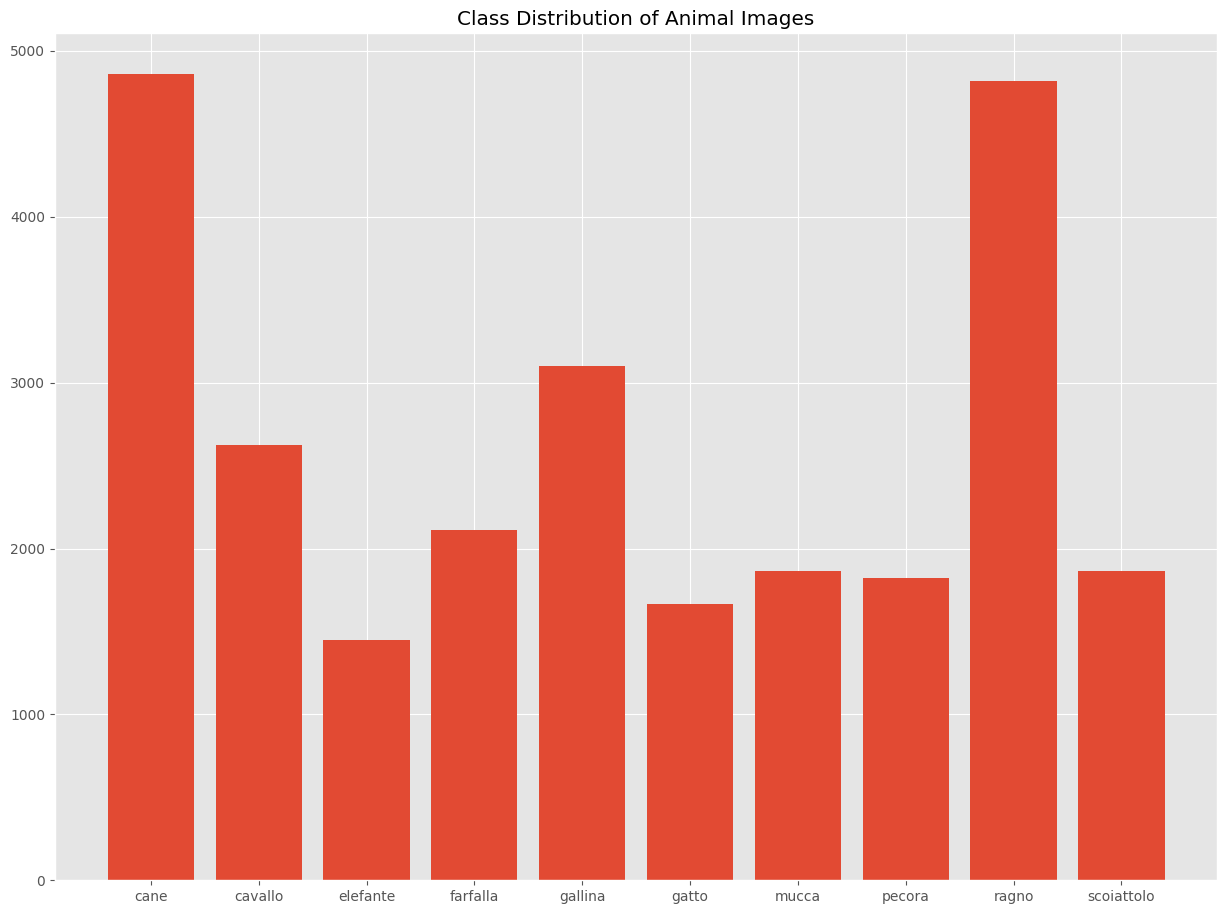

In [13]:
x = list(dic.keys())
y = list(dic.values())
plt.figure(figsize=(15, 11)) #Width , height
plt.title("Class Distribution of Animal Images")
plt.bar(x, y)

In [14]:
#Creating encoded labels for the animals 

animal_key = {}
count = 0 
main_dir = "raw-img"

for i in os.listdir(main_dir):
    animal_key[i] = count
    count += 1 
animal_key

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

In [15]:
#Creating a csv with image paths before using our custom data loader

main_dir = "raw-img" 
train_img_paths = []
train_labels = []
test_img_paths = []
test_labels = []

counter = 0

for i in os.listdir(main_dir):
    img_folder = os.path.join(main_dir, i)
    for j in os.listdir(img_folder):
        img_path = os.path.join(img_folder, j)
        if(counter % 6 == 0):
            test_img_paths.append(img_path)
            test_labels.append(animal_key[i])
        else:
            train_img_paths.append(img_path)
            train_labels.append(animal_key[i]) 
        counter += 1

data = pd.DataFrame([train_img_paths, train_labels])
data = data.transpose()
data.to_csv("train.csv", index=None)
print("Training Images are ",len(train_img_paths))

data = pd.DataFrame([test_img_paths, test_labels])
data = data.transpose()
data.to_csv("test.csv", index=None)
print("Testing Images are ",len(test_img_paths))



Training Images are  21815
Testing Images are  4364


In [16]:
class CustomDatasetLoader(Dataset):
    def __init__(self, csv_path, transform=None): #Init function runs only once when instantiating the Dataset object
        self.img_info = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self): #Returns the total number of data points
        return len(self.img_info)

    def __getitem__(self, index): #Should return the image and label from the data source as per the "index" value iterated over the length
        img_path = self.img_info.iloc[index, 0]
        img = read_image(img_path, mode=ImageReadMode.RGB)
        label = self.img_info.iloc[index, 1]
        if self.transform:
            img = self.transform(img)
        return img, label 

In [17]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),  
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])


test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])
#The values for normalization and standardization are given as per the recommended values from https://pytorch.org/vision/0.9/models.html

In [18]:
train_data = CustomDatasetLoader("train.csv", train_transform)
test_data = CustomDatasetLoader("test.csv", test_transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=128)
test_loader = DataLoader(test_data, shuffle=True, batch_size=128)

# Basic Transfer Learning

Fixed Feature Extractor

All the layers are frozen except for the last classification layer/s which is also modified as the number of classes prediction has to be same as our use case

In [25]:
model = torchvision.models.googlenet(pretrained=True)

C:\Users\Snowwolf\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Snowwolf\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
for parameter in model.parameters():
    parameter.requires_grad = False #the .requires_grad=True by default for all layers

model.fc = torch.nn.Linear(1024, 10)

for i in model.fc.parameters():
    i.requires_grad = True 

In [27]:
#Defining device 

if torch.cuda.is_available():
    print("GPU Available")
    device = torch.device("cuda")
else:
    print("Device is CPU")
    device = torch.device("cpu")

model = model.to(device)

GPU Available


In [28]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#Decay LR by a factor of 0.1 every 5 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [29]:
#timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#writer = SummaryWriter("runs/classifier_{}".format(timestamp))


training_accuracy_list = []
training_loss_list = []
length = []

def model_training(total_epochs, optimizer, criterion, model, device):
    counter= 0
    for epoch in range(total_epochs):
        print(f"Epoch :{epoch}")

        #Make model trainable | Gradien tracking is on 
        model.train()
        #One pass over data
        running_loss = 0.
        running_accuracy = 0.
        total_samples = 0.

        for inputs, targets in tqdm(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad() #Zero the gradients for every batch
            outputs = model(inputs) #Predictions for this batch
            loss = criterion(outputs, targets) #Computer loss and its gradients
            loss.backward()
            optimizer.step() #Adjust learning weights 
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)  # Assuming classification
            running_accuracy += torch.sum(preds == targets).item()
            total_samples += inputs.size(0)

        training_accuracy_result = running_accuracy / total_samples
        training_accuracy_list.append(training_accuracy_result)
        loss_result = float(running_loss / total_samples)
        training_loss_list.append(loss_result)
        length.append(counter)
        counter += 1
        print(f"For Batch size {len(train_loader)} images\nLoss ={loss_result}") 
        print(f"Training Accuracy : {training_accuracy_result}")
    return model 


In [30]:
a = time.time()
model = model_training(10, optimizer, criterion, model, device)
print("Total training time is {} seconds".format(time.time()-a))

Epoch :0


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.010201521740029662
Training Accuracy : 0.6967224386889754
Epoch :1


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.004487031430463684
Training Accuracy : 0.9146000458400183
Epoch :2


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.0032523683634969364
Training Accuracy : 0.9282145312858125
Epoch :3


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.00272714526533616
Training Accuracy : 0.931194132477653
Epoch :4


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.002436791051972385
Training Accuracy : 0.9323401329360532
Epoch :5


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.0022291942416542364
Training Accuracy : 0.9359614943845977
Epoch :6


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.0020990293458490066
Training Accuracy : 0.9362365344946137
Epoch :7


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.0020075236298801318
Training Accuracy : 0.937795095118038
Epoch :8


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.0019252485893419132
Training Accuracy : 0.9388952555581023
Epoch :9


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.0018230537537066128
Training Accuracy : 0.9426541370616548
Total training time is 770.72998046875 seconds


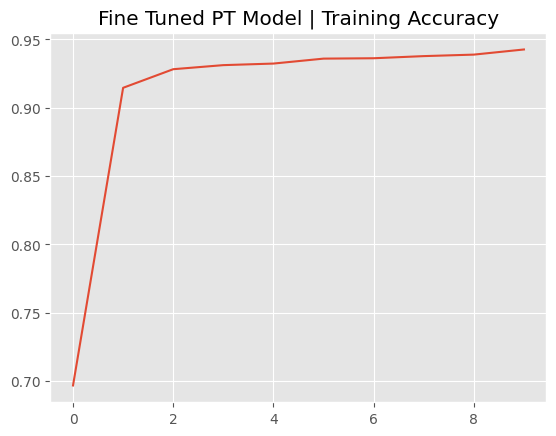

In [33]:
plt.title("Fine Tuned PT Model | Training Accuracy")
plt.plot(length, training_accuracy_list)

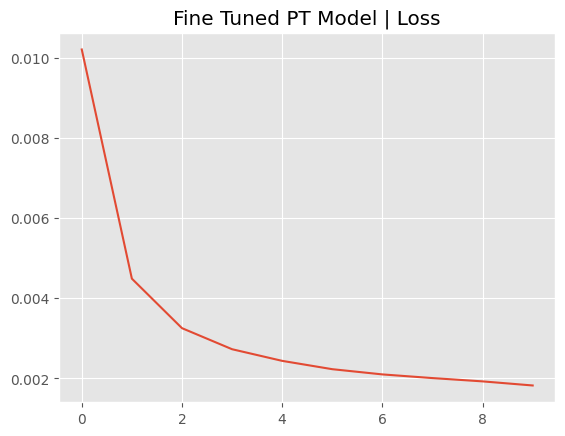

In [34]:
plt.title("Fine Tuned PT Model | Loss")
plt.plot(length, training_loss_list)

In [35]:
torch.save(model, "finetuned.pth") #Saveing with structure of class together with the model

In [36]:
with open("results/finetune.txt", "w") as file:
    file.write("Training Accuracy" +"\t" + "Loss Values" + "\n")
    for index, i in enumerate(length):
        file.write(str(training_accuracy_list[index]) + "\t" + str(training_loss_list[index]) + "\n")

In [37]:
#Count total number of parameters in PyTorch Model
sum = 0
for layer in model.parameters():
    sum += layer.numel()

print("Total number of parameters are ", sum)

Total number of parameters are  5610154


In [41]:
#Inferencing 

img_path = "raw-img\scoiattolo\OIP-zzy5kEbHuGBWXZ3c-D85aAHaE8.jpeg"
img = read_image(img_path, mode=ImageReadMode.RGB)
img = torchvision.transforms.Resize((224, 224))(img)
img = img.unsqueeze(0)
img = img.to(device).float()
print("shape of image is ", img.shape)

model.eval()
model = model.to(device)
with torch.no_grad():
    outputs = model(img)
    _, preds = torch.max(outputs, 1)

#preds[0].cpu().item()
preds

shape of image is  torch.Size([1, 3, 224, 224])


tensor([8], device='cuda:0')

Note :- I see that PyTorch can take dynamic shapes as inputs but the accuracy differs a lot which does make sense i guess.

In [42]:
x = torch.rand((212, 3, 224, 224)).to(device).float()
x.size()
model.eval()
model = model.to(device)
with torch.no_grad():
    outputs = model(x)
    _, preds = torch.max(outputs, 1)

In [6]:
model = torch.load("finetuned.pth")

In [9]:
#GPU Inference Comparison

batch_sizes = [1, 8, 32, 64, 128, 256]
ts = []
device = torch.device("cuda")

with torch.no_grad():
    for size in batch_sizes:
        x = torch.rand(size, 3, 224, 224).to(device).float()
        a = time.time()
        outputs = model(x)
        ts.append(time.time()-a)

torch.cuda.empty_cache()

ts

[0.010001659393310547,
 0.010002851486206055,
 0.009001970291137695,
 0.011002779006958008,
 0.01200246810913086,
 0.015003442764282227]

In [10]:
#CPU Inference Comparison

batch_sizes = [1, 8, 32, 64, 128, 256]
ts = []
device = torch.device("cpu")
model.eval().to(device)

with torch.no_grad():
    for size in batch_sizes:
        x = torch.rand(size, 3, 224, 224).to(device).float()
        a = time.time()
        outputs = model(x)
        ts.append(time.time()-a)

ts

[0.0969247817993164,
 0.25744009017944336,
 0.953176736831665,
 1.7825064659118652,
 3.7569615840911865,
 7.768420457839966]

In [19]:
#Evaluation 

device = torch.device("cpu")
model.eval().to(device)
correct, total = 0., 0.
with torch.no_grad():
    for data, target in tqdm(test_loader):
        output = model(data)
        _, predictions = torch.max(output, 1)
        total += target.size(0)
        correct += (predictions == target).sum().item()
print(correct / total)

  0%|          | 0/35 [00:00<?, ?it/s]

0.30614115490375804


# Dynamic Quantization

In [20]:
model = torch.load("finetuned.pth")

In [21]:
import torch.quantization as quant

model.eval().to(device="cpu")

quantized_model = quant.quantize_dynamic(model, 
                                         {torch.nn.Linear}, 
                                         dtype=torch.qint8)

In [22]:
torch.save(quantized_model, "int8_dynamic_quantization.pth")
#From 22,125 KB to 22,097 KB
#around 0.1% reduction in memory footprint
#Had seen 30% reduction for MobileNetV3, but then again is it the architecture or the small size?

In [23]:
model = torch.load("int8_dynamic_quantization.pth")

batch_sizes = [1, 8, 32, 64, 128, 256]
ts = []


with torch.no_grad():
    for size in batch_sizes:
        x = torch.rand(size, 3, 128, 128).float()
        a = time.time()
        outputs = quantized_model(x)
        ts.append(time.time()-a)

ts

c:\Users\Snowwolf\miniconda3\envs\analytics\Lib\site-packages\torch\_utils.py:382: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


[0.03500699996948242,
 0.09802126884460449,
 0.3098125457763672,
 0.6042380332946777,
 1.3203425407409668,
 2.350365161895752]

I tried to run on GPU but for X86 system and the current version of the library the support for these opearators are not there for Int8

In [24]:
#Tensor comparison 

data, targets = next(iter(train_loader))

data = data.to(device="cpu")

original_output = model(data)
quantized_output = quantized_model(data)
comparison = torch.allclose(original_output, quantized_output, atol=1e-1)
comparison

True

In [25]:
device = torch.device("cpu")
quantized_model.eval().to(device)
correct, total = 0., 0.
with torch.no_grad():
    for data, target in tqdm(test_loader):
        output = quantized_model(data)
        _, predictions = torch.max(output, 1)
        total += target.size(0)
        correct += (predictions == target).sum().item()
print(correct / total)

  0%|          | 0/35 [00:00<?, ?it/s]

0.9463794683776352


# Static Quantization 